In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from utils import *
from model import * 

In [2]:
def convert_params(params): 
    ''' 
    lambda, gamma, mu, c, b, sigma_d, 
    '''
    c = params[3]
    gamma = params[1]
    J = np.array([[-params[0], params[2]], [-c*params[0], -gamma+c*params[2]]])
    B = np.diagflat([params[5]**2, gamma])
    Dh = B[0, 0] 
    B[1, 0] += c*Dh
    B[0, 1] = B[1, 0] 
    B[1, 1] += c*c*Dh
    return J, B 

def flow(coor): 
    rhs = np.einsum('ij,jkl->ikl', J, coor)
    rhs[1] -= beta*coor[1]**3 
    return rhs

In [3]:
# simulation parameter 
dt = 5e-3
n_frames = 5000
T = 0.033*n_frames
n_repeats = 1

# Write in an extremely long persistence time but no coupling 
gamma = 1e-1 
c = 0 
mu = 0.1
epsilon = 0.25
beta = 88/(4/gamma)

params = [epsilon, gamma, mu, c, beta, 0.044]
print(params)

# # MLE 

# epsilon, gamma, mu, c, beta =  0.17, 0.75, 0.09, 17, 17
# params = [epsilon, gamma, mu, c, beta, 0.03]

J, B = convert_params(params)
print('J: ', J)
print('B: ', B)
print('eigenvals: ', np.linalg.eigvals(J))

def det_rhs(t, y): 
    rhs = J @ y 
    rhs[1] -= beta*y[1]**3 
    return rhs

t_eval = np.linspace(0, T, n_frames)
det_res = solve_ivp(det_rhs, [0, T], [0.2, 0.6], method='LSODA', t_eval=t_eval)

[0.25, 0.1, 0.1, 0, 2.2, 0.044]
J:  [[-0.25  0.1 ]
 [ 0.   -0.1 ]]
B:  [[0.001936 0.      ]
 [0.       0.1     ]]
eigenvals:  [-0.25 -0.1 ]


/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_44034/428448700.py:19: RuntimeWarning: divide by zero encountered in divide
  plt.plot(((-gamma + c*mu)*y - beta*y**3)/(c*epsilon), y, c='k')


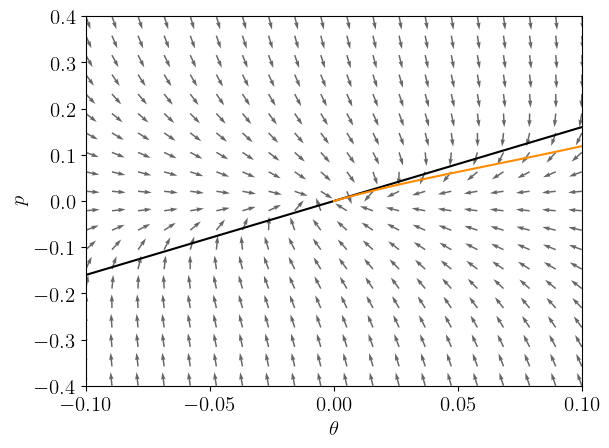

In [4]:
## Plot flow diagrams for decay regime and limit cycle  regime 
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)


x = np.linspace(-0.1, 0.1, 20)
y = np.linspace(-0.4, 0.4, 20)
X, Y = np.meshgrid(x, y)
coor = np.stack([X, Y], axis=0)

x = np.linspace(-0.1, 0.1, 100)
y = np.linspace(-0.4, 0.4, 100)

v = flow(coor)
v /= np.linalg.norm(v, axis=0)


plt.quiver(X, Y, v[0], v[1], alpha=0.6)
plt.plot(((-gamma + c*mu)*y - beta*y**3)/(c*epsilon), y, c='k')
plt.plot(x, mu*y/epsilon, c='k')
plt.plot(det_res.y[0], det_res.y[1], c='DarkOrange')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p$')
plt.xlim([x[0], x[-1]])
plt.ylim([y[0], y[-1]])
# plt.savefig('Figures/FHN2.pdf')
plt.show() 

In [5]:
# # estimation from spinning rod + direct measurements 

params = [epsilon, gamma, mu, c, beta, 0.044]
print(params)
n_repeats = 8
m = FHN(params, convert_params)
results = m.evolve(T, dt, int(n_frames), n_repeats)

[0.25, 0.1, 0.1, 0, 2.2, 0.044]


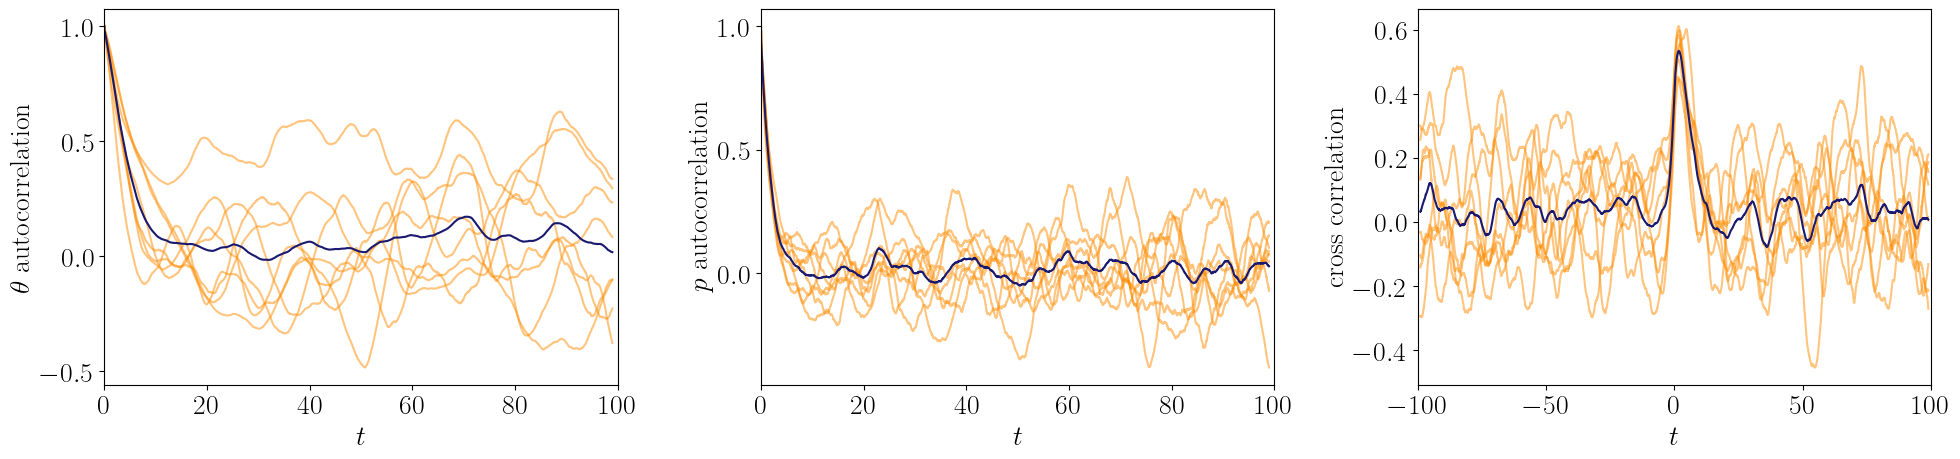

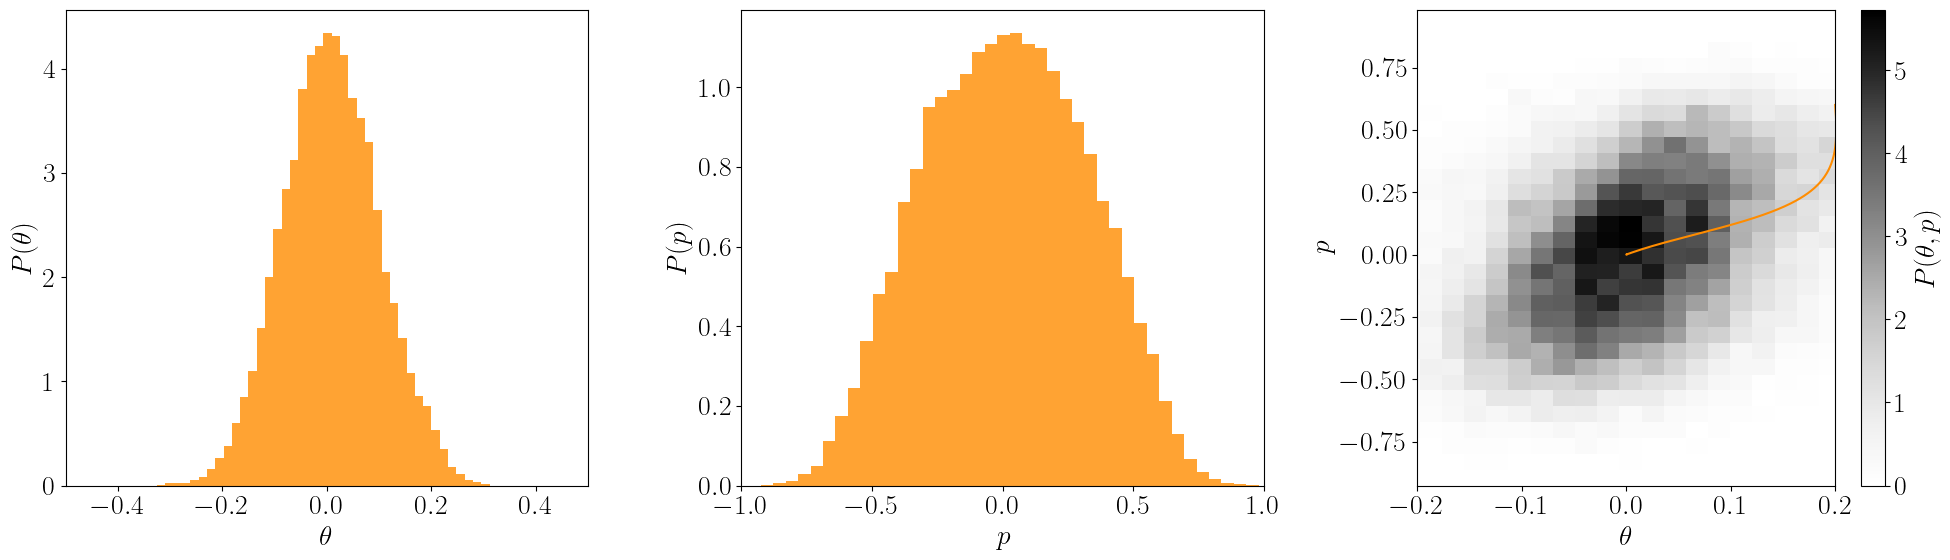

In [7]:
_, _, _= plot_corr(results, 3000, 3.3e-2, tex=True)
# plt.ylim([-0.3, 0.4])
plt.savefig('Figures/long_pers_t_coor.pdf')
plt.show() 

fig, axes = plot_overall_dist(results, tex=True)
axes[2].plot(det_res.y[0], det_res.y[1], color='darkorange')
axes[2].set_xlim([-0.2, 0.2])
plt.savefig('Figures/long_pers_t_dist.pdf')
plt.show() 